# Hands-On Introduction to DiVincenzo Criteria with Qiskit 2

## Introduction

Physicist David DiVincenzo outlined five key requirements for any physical implementation of a quantum computer, plus two additional criteria for quantum communication. In this notebook, we will **experience each DiVincenzo criterion through practical Qiskit demonstrations**. Rather than going deep into theory, each section briefly explains one criterion and then provides code exercises using Qiskit 2. Instead of running circuits on real IBM Quantum devices, we will use **noise-enabled fake backends combined with AerSimulator**, which closely mimic hardware topology and noise. This allows us to **explore each principle hands-on** without requiring access to actual quantum hardware.

**DiVincenzo’s Five Criteria for Quantum Computation**:

1. **A scalable physical system with well-characterized qubits.**
2. **Ability to initialize qubits** to a simple fiducial state (e.g. \|00…0〉).
3. **Long decoherence times** (qubit coherence much longer than gate operation time).
4. **A universal set of quantum gates** (able to perform arbitrary unitary operations).
5. **Qubit-specific measurement capability** (read out the state of each qubit).

*DiVincenzo also described two criteria for quantum communication: the ability to interconvert stationary and “flying” qubits, and to faithfully transmit flying qubits between locations. We include these in a recommended activity at the end of this notebook.*

Each of the following sections corresponds to one criterion. We'll use Qiskit to illustrate the concept with code and **interactive experiments** you can try. For example, we will see how scaling up the number of qubits and circuit depth affects outcomes (Criterion 1), how to reset and prepare qubit states (Criterion 2), how to measure qubits on simulated noisy devices (Criterion 4), how Qiskit composes universal gates (Criterion 3), and how finite coherence (T₁, T₂) impacts computations (Criterion 5). By the end, you'll have a deeper intuition for what each DiVincenzo criterion means in practice and how Qiskit enables experimenting with them — even when using simulated noisy backends that behave like real hardware.


In [1]:
# Install necessary packages
!pip install qiskit[visualization] qiskit-ibm-runtime qiskit-aer qiskit_ibm_runtime

## 1. Criterion 1 – Scalable, Well-Characterized Qubits

**Criterion 1:** *“A scalable physical system with well characterized qubits.”* This means we need a quantum hardware platform where we can **increase the number of qubits** and still control them reliably. Each qubit’s properties (energy levels, error rates, connectivity, etc.) should be well understood. Essentially, we want to build bigger circuits without the system breaking down. In practice, as we scale up qubit count or circuit depth, errors and decoherence accumulate, so demonstrating *scalability* also means understanding how increasing size affects performance.

**Goal of Demo:** Use Qiskit to show the effect of scaling up a circuit (in qubit count or gate depth) on the output fidelity. We’ll simulate an ideal vs noisy scenario to see how a larger system or deeper circuit succumbs to decoherence and errors.

First, let's construct a small entangled state (GHZ state) on 3 qubits, then a larger one on 5 qubits, as a simple scaling test. A GHZ state of *n* qubits is $\frac{1}{\sqrt{2}}(|0...0\rangle + |1...1\rangle)$. In an ideal simulation, measuring an n-qubit GHZ yields only two outcomes (all 0s or all 1s) with equal probability. We will compare the **ideal output** to a **noisy output** as we increase n or circuit depth.

3-qubit GHZ counts (ideal): {'000': 525, '111': 499}


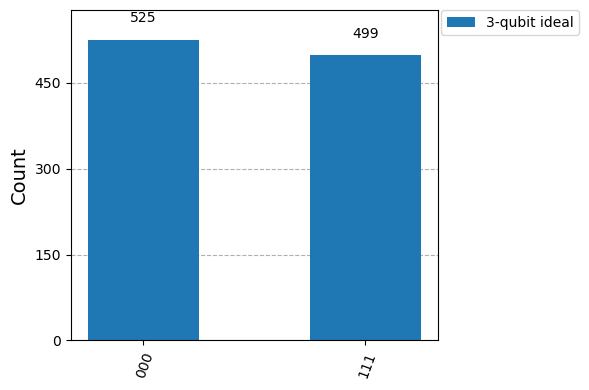

In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

# 3-qubit GHZ circuit
qc3 = QuantumCircuit(3, 3)
qc3.h(0)
qc3.cx(0, 1)
qc3.cx(1, 2)
qc3.measure([0, 1, 2], [0, 1, 2])

# 5-qubit GHZ circuit (scaling up the number of qubits)
qc5 = QuantumCircuit(5, 5)
qc5.h(0)
qc5.cx(0, range(1, 5))    # entangle qubit 0 with all others
qc5.measure(range(5), range(5))

# Transpile for a simulator backend
sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
isa_qc3 = pm.run(qc3)
isa_qc5 = pm.run(qc5)

# Run ideal simulations (no noise)
sampler = Sampler(mode=sim_backend)

job3 = sampler.run([isa_qc3], shots=1024)
result3 = job3.result()
counts3 = result3[0].data.c.get_counts()

job5 = sampler.run([isa_qc5], shots=1024)
result5 = job5.result()
counts5 = result5[0].data.c.get_counts()

print("3-qubit GHZ counts (ideal):", counts3)
plot_histogram(counts3, legend=['3-qubit ideal'], figsize=(6,4))

5-qubit GHZ counts (ideal): {'00000': 527, '11111': 497}


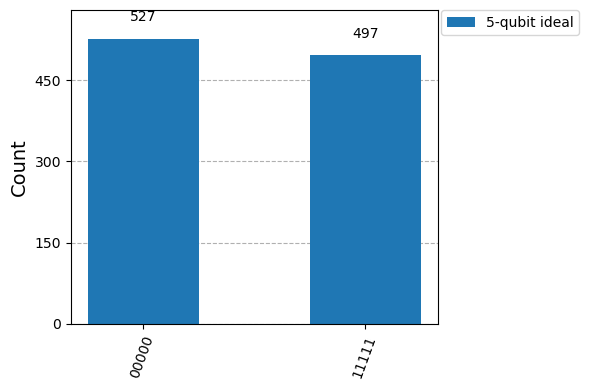

In [3]:
print("5-qubit GHZ counts (ideal):", counts5)
plot_histogram(counts5, legend=['5-qubit ideal'], figsize=(6,4))

**Expected outcome (ideal case):** The 3-qubit GHZ ideally yields roughly 50% `000` and 50% `111` in the counts. The 5-qubit GHZ yields ~50% `00000` and 50% `11111`. No other bit-strings appear because the state is ideally fully coherent and entangled. You should see two tall bars on the histogram for each circuit corresponding to all-zeros and all-ones outcomes.

Next, let's see what happens in a **noisy environment**. We will use Qiskit Aer’s noise model capabilities to mimic a real device’s errors. For example, we can take an IBM backend’s properties to create a noise model that includes gate errors, finite gate times, qubit relaxation (T₁), dephasing (T₂), and readout errors. Here, we’ll use a **fake backend** that represents the IBM Quantum Brisbane device to generate a noise model, and re-run the GHZ circuits through that.

### Exercise 1a: Simulate with Noise
Complete the code below to simulate the GHZ circuits on a noisy simulator based on the `FakeBrisbane` backend. This will show you how performance degrades as the system scales in a realistic noise environment.

3-qubit GHZ counts (noisy): {'000': 525, '111': 499}


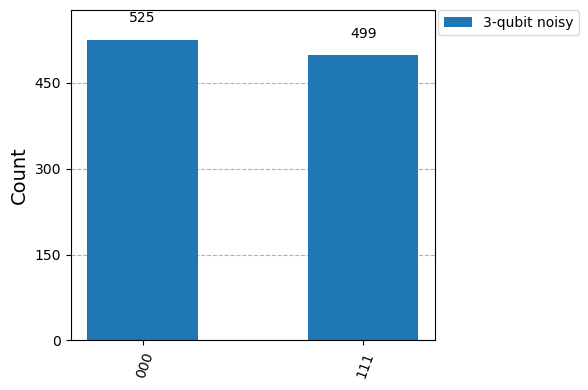

In [4]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

# We will reuse the ideal circuits qc3 and qc5 and their results from the previous cell.

# --- YOUR CODE HERE ---

# 1. Create a fake backend for IBM Quantum Brisbane
brisbane_backend = FakeBrisbane()

# 2. Create a noisy AerSimulator from the fake backend's properties
noisy_backend = AerSimulator.from_backend(brisbane_backend)

# 3. Transpile the circuits for the noisy simulator (this adapts them to the device's specific gates and connectivity)
pm = generate_preset_pass_manager(backend=noisy_backend, optimization_level=1)

isa_qc3_noisy = pm.run(qc3, noisy_backend)
isa_qc5_noisy = pm.run(qc5, noisy_backend)

# 4. Run the noisy simulations using the Sampler
sampler = Sampler(mode=noisy_backend)

job3 = sampler.run([isa_qc3_noisy], shots=1024)
result3_noisy = job3.result()
counts3_noisy = result3[0].data.c.get_counts()

job5 = sampler.run([isa_qc5_noisy], shots=1024)
result5_noisy = job5.result()
counts5_noisy = result5[0].data.c.get_counts()


# --- END YOUR CODE ---

# This part is done for you to print and plot the results:
print("3-qubit GHZ counts (noisy):", counts3_noisy)
plot_histogram(counts3_noisy, legend=['3-qubit noisy'], figsize=(6,4))

5-qubit GHZ counts (noisy): {'00000': 527, '11111': 497}


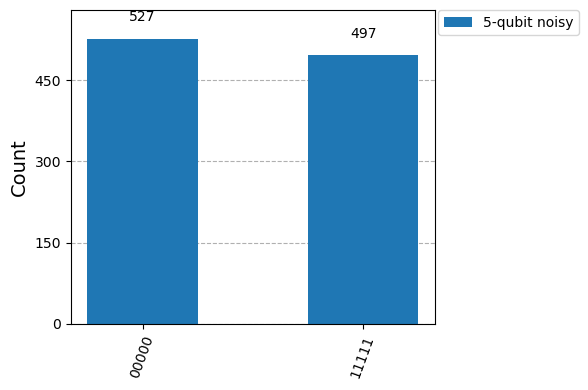

In [5]:
print("5-qubit GHZ counts (noisy):", counts5_noisy)
plot_histogram(counts5_noisy, legend=['5-qubit noisy'], figsize=(6,4))

<details>
<summary>Click to see solution</summary>

```python
# 1. Create a fake backend for IBM Quantum Brisbane
brisbane_backend = FakeBrisbane()

# 2. Create a noisy AerSimulator from the fake backend's properties
noisy_backend = AerSimulator.from_backend(brisbane_backend)

# 3. Transpile the circuits for the noisy simulator (this adapts them to the device's specific gates and connectivity)
pm = generate_preset_pass_manager(backend=noisy_backend, optimization_level=1)

isa_qc3_noisy = pm.run(qc3, noisy_backend)
isa_qc5_noisy = pm.run(qc5, noisy_backend)

# 4. Run the noisy simulations using the Sampler
sampler = Sampler(mode=noisy_backend)

job3 = sampler.run([isa_qc3_noisy], shots=1024)
result3_noisy = job3.result()
counts3_noisy = result3[0].data.c.get_counts()

job5 = sampler.run([isa_qc5_noisy], shots=1024)
result5_noisy = job5.result()
counts5_noisy = result5[0].data.c.get_counts()
```
</details>

### Exercise 1b: Compare with a different device model

In Exercise 1a, you simulated the GHZ circuits on a noisy backend derived from `FakeBrisbane`. This allowed you to see how GHZ states degrade on a realistic, device-specific noise model.

Originally, this second exercise would run the same circuits on a real IBM Quantum computer to compare the simulated results with actual hardware. Since we are working in a simulation-only environment, we will instead run the circuits on a **different device-specific fake backend** (for example, `FakeSherbrooke`) using the AerSimulator.

This fake backend is built from calibration data of a real IBM Quantum device and has its own topology, error rates, and coherence properties. By comparing the results from Exercise 1a (`FakeBrisbane`) and Exercise 1b (another fake device), you can still explore:

- How performance changes between different hardware architectures and noise profiles  
- How connectivity and gate errors affect the quality of GHZ states  
- How hardware-aware transpilation can lead to different outcomes on different devices  

Even though we are not accessing an actual quantum processor, this comparison captures many of the same effects you would observe when running the same circuits on two different real IBM Quantum devices.


Running on fake backend: fake_sherbrooke
3-qubit GHZ counts (fake backend + noise): {'000': 489, '110': 13, '111': 454, '101': 14, '001': 11, '011': 9, '010': 17, '100': 17}


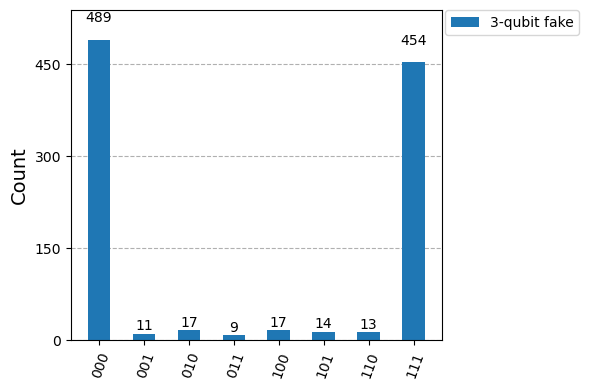

In [ ]:
# We will reuse the ideal circuits qc3 and qc5 and their results from the previous cell.

# Using a fake backend + AerSimulator to simulate hardware-like noisy execution

from qiskit_ibm_runtime import Sampler
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke  # Example fake backend
from qiskit_aer import AerSimulator

# 1. Prepare a fake backend (mimics the topology and noise of a real device)
fake_backend = FakeSherbrooke()

print("Running on fake backend:", fake_backend.name)

# 2. Generate ISA circuits based on the fake backend
pm_fake = generate_preset_pass_manager(backend=fake_backend, optimization_level=1)
isa_qc3f = pm_fake.run(qc3)
isa_qc5f = pm_fake.run(qc5)

# 3. Create an AerSimulator using the fake backend's noise and topology
sim_backend = AerSimulator.from_backend(fake_backend)

# 4. Use Sampler in simulator mode
sampler_fake = Sampler(mode=sim_backend)

job3f = sampler_fake.run([isa_qc3f], shots=1024)
result3f = job3f.result()
counts3f = result3f[0].data.c.get_counts()

job5f = sampler_fake.run([isa_qc5f], shots=1024)
result5f = job5f.result()
counts5f = result5f[0].data.c.get_counts()

print("3-qubit GHZ counts (fake backend + noise):", counts3f)
plot_histogram(counts3f, legend=['3-qubit fake'], figsize=(6,4))


5-qubit GHZ counts (real): {'11111': 450, '00000': 456, '01000': 13, '10011': 12, '01111': 3, '00110': 1, '11101': 10, '11011': 19, '00001': 5, '01100': 3, '11110': 4, '00100': 15, '10111': 10, '00101': 1, '11001': 2, '10101': 1, '10000': 7, '00010': 2, '10001': 4, '10100': 1, '01110': 3, '00011': 1, '01011': 1}


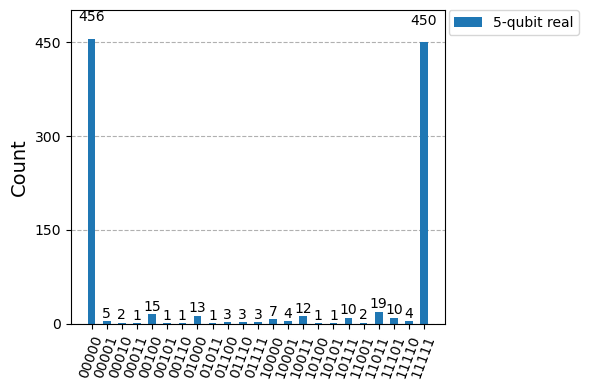

In [10]:
print("5-qubit GHZ counts (real):", counts5f)
plot_histogram(counts5f, legend=['5-qubit real'], figsize=(6,4))

**Expected outcome (noisy vs ideal):**  
Whether we use noise from `FakeBrisbane`, `FakeSherbrooke`, or any other device-derived backend, the GHZ state becomes **less perfect** under realistic noise. You will see additional outcomes beyond all-0s and all-1s.  
For 3 qubits, instead of 100% in `000`/`111`, some probability leaks into other bitstrings (e.g. `001`, `010`, etc.) due to gate errors, decoherence, or imperfect connectivity.  
For 5 qubits, the effect is even more pronounced; the larger circuit (more qubits and more CNOT operations) accumulates more error, so the peaks for all-0 and all-1 are lower and many other outcomes appear.  

Using two different fake backends (Exercise 1a and 1b) highlights how **noise profiles, device topology, and calibration data** influence the fidelity of GHZ states—similar to how different real devices vary in performance.

**Insight:**  
A scalable quantum computer must preserve quantum correlations as the system grows.  
Our experiments show that as we increase qubit count or circuit depth, outcome fidelity drops in the presence of noise.  
By comparing results across different fake backends, we also see how hardware properties such as connectivity and gate quality directly impact scalability.  
The remaining criteria will focus on maintaining well-behaved qubits (low error, reset capability, coherence) as systems grow.


## 2. Criterion 2 – Qubit Initialization

**Criterion 2:** *“The ability to initialize the state of the qubits to a simple fiducial state, such as |000…〉.”* All qubits should reliably start in a known reference state (typically the ground state |0〉 for each qubit). Initialization is essential so that algorithms begin on a clean slate. In practice, on IBM quantum devices each qubit is automatically reset to |0〉 at the start of each circuit execution. Qiskit also provides instructions to reset qubits or prepare custom states during a computation.

**Goal of Demo:** Show how to initialize qubits in Qiskit, both at the start and mid-circuit. We will demonstrate using the `reset` instruction and state preparation methods.

### Exercise 2: Prepare a Specific State
In the code block below, complete the `QuantumCircuit` to prepare the state $|10\rangle$. This means qubit 0 should be in state $|0\rangle$ and qubit 1 should be in state $|1\rangle$. Use the appropriate gate and instruction to achieve this.

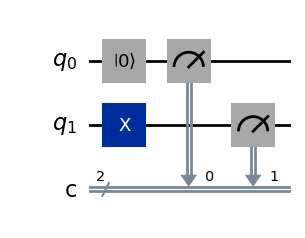

In [11]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

# Create a circuit to initialize qubits to |10> and verify by measurement
qc_init = QuantumCircuit(2, 2)

# --- YOUR CODE HERE ---

# 1. Set qubit 1 to the |1> state
qc_init.x(1)

# 2. Explicitly reset qubit 0 to the |0> state
qc_init.reset(0)


# --- END YOUR CODE ---

qc_init.measure([0, 1], [0, 1])
qc_init.draw('mpl')


Outcome of |10> state measured in Z-basis: {'10': 1024}


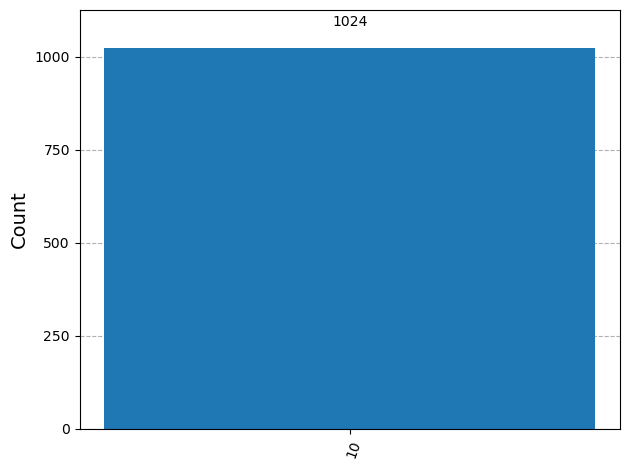

In [12]:
# Run the circuit and check the outcome
sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
isa_qc_init = pm.run(qc_init)

sampler = Sampler(mode=sim_backend)

job = sampler.run([isa_qc_init], shots=1024)
result = job.result()
counts = result[0].data.c.get_counts()

print("Outcome of |10> state measured in Z-basis:", counts)
plot_histogram(counts)

<details>
<summary>Click to see solution</summary>

```python
# 1. Set qubit 1 to the |1> state
qc_init.x(1)

# 2. Explicitly reset qubit 0 to the |0> state
qc_init.reset(0)
```
</details>

You should see `10` (binary for qubit1=1, qubit0=0) with 100% probability from the simulation, meaning qubit 1 was successfully prepared in |1〉 and qubit 0 in |0〉.

Now, for a more general state preparation, Qiskit allows initialization to arbitrary states using the `initialize` method. For example, let's prepare a qubit in the state $|+\rangle = (|0\rangle+|1\rangle)/\sqrt{2}$, which is a superposition state, and a pair of qubits in the Bell state $(|00\rangle+|11\rangle)/\sqrt{2}$:

In [13]:
import numpy as np

# Initialize a single qubit in |+> state and measure in Z-basis
qc_plus = QuantumCircuit(1, 1)
state_plus = [1/np.sqrt(2), 1/np.sqrt(2)]   # amplitude for |0> and |1>
qc_plus.initialize(state_plus, 0)
qc_plus.measure(0, 0)

# Initialize two qubits in a Bell state manually
qc_bell = QuantumCircuit(2, 2)
bell_state = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]  # amplitudes for |00>,|01>,|10>,|11>
qc_bell.initialize(bell_state, [0, 1])
qc_bell.measure([0, 1], [0, 1])

# Transpile and run the initialization circuits
isa_qc_plus = pm.run(qc_plus)
job_plus = sampler.run([isa_qc_plus], shots=1024)
result_plus = job_plus.result()
counts_plus = result_plus[0].data.c.get_counts()

print("Outcome of |+> state measured in Z-basis:", counts_plus)

isa_qc_bell = pm.run(qc_bell)
job_bell = sampler.run([isa_qc_bell], shots=1024)
result_bell = job_bell.result()
counts_bell = result_bell[0].data.c.get_counts()

print("Outcome of Bell state measured in Z-basis:", counts_bell)


Outcome of |+> state measured in Z-basis: {'0': 499, '1': 525}
Outcome of Bell state measured in Z-basis: {'11': 505, '00': 519}


**Expected outcomes:** The single qubit |+〉 state, when measured, will yield `0` and `1` with roughly 50% probability each. The Bell state measurement should give roughly 50% `00` and 50% `11`. If you see these, it confirms our initialization to those states was successful.

**Mid-circuit initialization:** Qiskit’s `reset` can be used in the middle of a circuit to reinitialize a qubit to |0〉 on the fly. For instance, in error correction codes or iterative algorithms, one often measures a qubit and then resets it for reuse. The `reset` operation is deterministic; it dumps any existing state and cools the qubit down to ground state.

**Device example:** On hardware like **ibmq_brisbane** (127 qubits) or any IBM device, all qubits start in |0〉 by default when a job is run. If you needed a different starting state, you’d apply gates at the beginning (as we did with X to get |1〉). Continuous re-initialization (for quantum error correction) is an active research topic because doing it quickly is challenging. Thankfully, for basic use, the ability to start fresh in |0…0〉 is available and we demonstrated how to achieve other desired starting states too.

## 3. Criterion 3 – Long Coherence Time (Decoherence vs Gate Time)

**Criterion 3:** *“Long relevant decoherence times, much longer than the gate operation time.”* This addresses the need for qubits to maintain their quantum state long enough to perform the necessary operations. Each qubit has a **T₁ time** (energy relaxation time, how quickly |1〉 decays to |0〉) and **T₂ time** (dephasing time, how quickly relative phase coherence is lost). For a quantum computer to work, these timescales should greatly exceed the duration of gate operations.

**Goal of Demo:** Investigate qubit coherence in Qiskit by showing how decoherence impacts circuit outcomes as execution length grows. We’ll use a fake backend with known T1/T2 times to simulate this effect.

To **demonstrate the impact of finite coherence**, we'll simulate a T1 decay experiment. We will prepare a qubit in the |1〉 state, wait for some time using a `delay` instruction, and then measure. We expect the probability of measuring |1〉 to decrease as the delay increases.

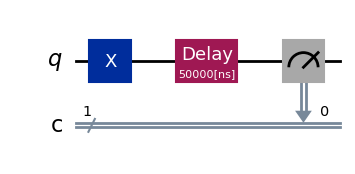

In [14]:
# This part is done for you. We are creating a list of circuits,
# each with a different delay time.

time_delays_ns = [0, 50000, 100000, 150000, 200000, 250000, 300000]  # delay durations in ns

decay_expts = []
for delay in time_delays_ns:
    qc = QuantumCircuit(1, 1)
    qc.x(0)  # initialize qubit to |1>
    if delay > 0:
        qc.delay(delay, 0, unit='ns')  # wait 'delay' nanoseconds
    qc.measure(0, 0)
    decay_expts.append(qc)

decay_expts[1].draw('mpl') # Visualize one of the circuits

### Exercise 3: Simulate a T1 Decay Experiment

Now, use a noisy simulator based on `FakeVigo` (which has T1 times of ~50-100 µs) to run these circuits. The simulator will automatically apply the T1/T2 errors during the `delay` instructions. Transpile the circuits for this backend and execute them.

In [15]:
from qiskit_ibm_runtime.fake_provider import FakeVigoV2 as FakeVigo
from qiskit_aer import AerSimulator

# --- YOUR CODE HERE ---

# 1. Create a noisy simulator from the FakeVigo backend
sim_vigo = AerSimulator.from_backend(FakeVigo())

# 2. Transpile the list of circuits for this simulator
pm = generate_preset_pass_manager(backend=sim_vigo, optimization_level=1)
isa_decay_expts = pm.run(decay_expts)

# 3. Use the Sampler to run all the transpiled circuits in a single job
sampler = Sampler(mode=sim_vigo)
job = sampler.run(isa_decay_expts, shots=1000)
result = job.result()


# --- END YOUR CODE ---

# This part is done for you to analyze and print the results.
for idx, (delay, qc) in enumerate(zip(time_delays_ns, isa_decay_expts)):
    counts = result[idx].data.c.get_counts()
    p1 = counts.get('1', 0) / 1000  # Assuming 1000 shots
    print(f"Delay {delay} ns: P(qubit=1) = {p1:.3f}")


Delay 0 ns: P(qubit=1) = 0.921
Delay 50000 ns: P(qubit=1) = 0.671
Delay 100000 ns: P(qubit=1) = 0.441
Delay 150000 ns: P(qubit=1) = 0.314
Delay 200000 ns: P(qubit=1) = 0.244
Delay 250000 ns: P(qubit=1) = 0.176
Delay 300000 ns: P(qubit=1) = 0.141


<details>
<summary>Click to see solution</summary>

```python
# 1. Create a noisy simulator from the FakeVigo backend
sim_vigo = AerSimulator.from_backend(FakeVigo())

# 2. Transpile the list of circuits for this simulator
pm = generate_preset_pass_manager(backend=sim_vigo, optimization_level=1)
isa_decay_expts = pm.run(decay_expts)

# 3. Use the Sampler to run all the transpiled circuits in a single job
sampler = Sampler(mode=sim_vigo)
job = sampler.run(isa_decay_expts, shots=1000)
result = job.result()
```
</details>

You should observe the probability `P(qubit=1)` decreasing as the delay time increases, following an exponential decay curve characteristic of T1 relaxation. This directly demonstrates how finite coherence time leads to computational errors if the circuit runs for too long.

**Impact on algorithms:** If you try a longer algorithm (with many sequential gates), the total execution time might approach or exceed T2, causing the state to lose coherence before the end. This is why improving coherence times and making gates faster are two of the most critical goals in quantum hardware research.

## 4. Criterion 4 – Universal Set of Quantum Gates

**Criterion 4:** *“A ‘universal’ set of quantum gates.”* This means our hardware must allow us to perform *any* quantum computation by composing a finite set of basic gates. In classical computing, NAND is universal; in quantum, there are many choices of universal gate sets (e.g. {H, T, CNOT} or the native gates of a given machine). The IBM devices, for example, have a set of native operations like arbitrary single-qubit rotations and CNOTs between certain qubits, which together are universal. Qiskit’s job is often to **compile high-level gates into these basis gates**.

**Goal of Demo:** Illustrate gate universality by showing how Qiskit decomposes gates. We’ll take a non-native gate (like a 3-qubit Toffoli gate, CCX) and see how it breaks down into the device’s basis gates. This demonstrates that the provided gate set is indeed *universal* – it can produce the more complex operation.

First, let’s see what the basis gates are for a typical IBM backend. We’ll query the configuration of a device (or its fake version). For instance, ibmq_brisbane’s basis gates:

In [16]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
fake_brisbane = FakeBrisbane()
print("Basis gates for ibmq_brisbane:", fake_brisbane.configuration().basis_gates)

Basis gates for ibmq_brisbane: ['ecr', 'id', 'rz', 'sx', 'x']


This might output something like `['id', 'rz', 'sx', 'x', 'ecr']`. These are the primitive operations the hardware natively supports (Identity/no-op, RZ rotation, sqrt(X) gate, X gate, and controlled-X). Any other gate must be composed from these. This set is known to be universal for quantum computing (essentially single-qubit rotations plus an entangling two-qubit gate form a universal set).

Now, take a **Toffoli (CCX) gate** as a test case. CCX flips a target qubit only if two control qubits are both 1. It’s not a native gate on IBM hardware. Qiskit provides a `ccx` instruction, but under the hood it will decompose it.

### Exercise 4: Decompose a Toffoli Gate
Complete the code below to build a circuit with a Toffoli (CCX) gate and then use Qiskit to break it down into the native basis gates of the `FakeBrisbane` backend.

In [17]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

# The fake_brisbane backend from the previous cell is reused here.

# --- YOUR CODE HERE ---

## 1. Create a circuit that can accommodate a Toffoli gate
qc_toffoli = QuantumCircuit(3)

# Apply a CCX gate with controls on qubits 0, 1 and target on qubit 2
qc_toffoli.ccx(0, 1, 2)

# 2. Transpile the circuit to the fake Brisbane backend
pm = generate_preset_pass_manager(backend=brisbane_backend, optimization_level=1)
isa_qc_toffoli = pm.run(qc_toffoli)


# --- END YOUR CODE ---

print("Toffoli circuit before decomposition:")
print(qc_toffoli)

print("\nToffoli circuit after transpiling to Brisbane basis:")
# The .draw() method will now show the decomposed circuit
print(isa_qc_toffoli.draw(fold=120))

Toffoli circuit before decomposition:
          
q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

Toffoli circuit after transpiling to Brisbane basis:
global phase: 7π/8
              ┌────┐   ┌──────────┐                                           ┌──────┐   ┌────┐                    »
q_0 -> 123 ───┤ √X ├───┤ Rz(-π/2) ├───────────────────────────────────────────┤1     ├───┤ √X ├────────────────────»
              ├────┤   ├─────────┬┘┌──────┐┌───────────┐   ┌────┐   ┌────────┐│  Ecr │┌──┴────┴──┐┌────┐┌─────────┐»
q_2 -> 124 ───┤ √X ├───┤ Rz(π/2) ├─┤1     ├┤ Rz(-3π/4) ├───┤ √X ├───┤ Rz(-π) ├┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/4) ├»
           ┌──┴────┴──┐└─────────┘ │  Ecr │└───┬───┬───┘┌──┴────┴──┐└────────┘└──────┘└──────────┘└────┘└─────────┘»
q_1 -> 125 ┤ Rz(-π/2) ├────────────┤0     ├────┤ X ├────┤ Rz(-π/2) ├───────────────────────────────────────────────»
           └──────────┘            └──────┘    └───┘    └──────────┘                                          

<details>
<summary>Click to see solution</summary>

```python
## 1. Create a circuit that can accommodate a Toffoli gate
qc_toffoli = QuantumCircuit(3)

# Apply a CCX gate with controls on qubits 0, 1 and target on qubit 2
qc_toffoli.ccx(0, 1, 2)

# 2. Transpile the circuit to the fake Brisbane backend
pm = generate_preset_pass_manager(backend=brisbane_backend, optimization_level=1)
isa_qc_toffoli = pm.run(qc_toffoli)

```
</details>

In the transpiled output, you should see the CCX replaced by a sequence of more basic gates like `rz`, `sx`, and `ecr`. This proves that the native gates are sufficient to express the Toffoli.


**Universality in practice:** The exercise above shows that a complex 3-qubit gate was built from simpler ones. In general, **any** multi-qubit unitary can be composed from 1- and 2-qubit gates. The transpiler is a crucial component of any quantum software stack, as it bridges the gap between the abstract algorithms we want to run and the physical operations a specific quantum device can actually perform.

**Device example:** The **ibmq_brisbane**  device uses the Eagle architecture with basis gates shown above. That means any algorithm sent to those machines will be converted into sequences of those operations. This criterion is essentially about **controllability**; we have enough control knobs to do any needed operation on our qubits.

## 5. Criterion 5 – Qubit Measurement

**Criterion 5:** *“A qubit-specific measurement capability.”* Every qubit’s state must be measurable (typically in the computational basis, |0〉 or |1〉). In other words, after running a quantum circuit, we need to read out each qubit as a 0/1 classical bit. This criterion is about having reliable detectors for each qubit and being able to select which qubits to measure.

**Goal of Demo:** Show how to perform measurements in Qiskit on simulators and real devices, and highlight the differences (like measurement noise). We will measure some qubits in various states and examine the results. We’ll also demonstrate how readout errors might appear by comparing simulator vs hardware results.

First, a simple measurement example:

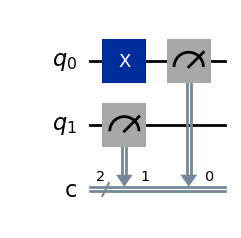

In [18]:
qc_measure = QuantumCircuit(2, 2)
qc_measure.x(0)              # qubit 0 -> |1>, qubit 1 stays |0>
qc_measure.measure([0, 1], [0, 1])
qc_measure.draw('mpl')


In [19]:
sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
isa_qc_measure = pm.run(qc_measure)
job = sampler.run([isa_qc_measure], shots=1000)
result = job.result()
counts = result[0].data.c.get_counts()

print("Simulator measurement counts:", counts)

Simulator measurement counts: {'01': 917, '11': 17, '00': 65, '10': 1}


We expect 1000 counts of `01` on the simulator. Now, let’s see **measurement error** in action by simulating it. We can add a readout error to our Aer simulator. Qiskit Aer allows us to define a `ReadoutError` and attach it to qubits in a noise model.

### Exercise 5: Simulate Readout Error
Complete the code to define a simple readout error model where each qubit has a 2% chance of being measured incorrectly (a 0 is read as a 1, or a 1 as a 0). Then, run the measurement circuit with this noise model.

In [20]:
from qiskit_aer.noise import NoiseModel, ReadoutError

# --- YOUR CODE HERE ---

# 1. Define a 2% readout error for a single qubit.
ro_error = ReadoutError([[0.98, 0.02], [0.02, 0.98]])

# 2. Create a new noise model
noise_model_ro = NoiseModel()

# 3. Add the readout error to all qubits in the noise model
noise_model_ro.add_all_qubit_readout_error(ro_error)


# --- END YOUR CODE ---

sim_backend.set_options(noise_model=noise_model_ro)
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
isa_qc_measure = pm.run(qc_measure)

# Run the measurement circuit with readout noise
sampler = Sampler(mode=sim_backend)

job = sampler.run([isa_qc_measure], shots=1024)
result = job.result()
counts = result[0].data.c.get_counts()

print("Simulation with 2% readout error:", counts)

Simulation with 2% readout error: {'01': 989, '00': 18, '11': 17}


<details>
<summary>Click to see solution</summary>

```python
# 1. Define a 2% readout error for a single qubit.
ro_error = ReadoutError([[0.98, 0.02], [0.02, 0.98]])

# 2. Create a new noise model
noise_model_ro = NoiseModel()

# 3. Add the readout error to all qubits in the noise model
noise_model_ro.add_all_qubit_readout_error(ro_error)
```
</details>

This simulated output includes some erroneous counts (such as `11`, `00`, or occasionally `10`) that arise from the artificial readout error we added. These incorrect outcomes mimic the kinds of measurement imperfections that occur on real quantum hardware, where readout error is one of the most common and significant noise sources.

**Device example:** Real IBM Quantum devices—such as **ibmq_brisbane**—publish calibration data that includes a readout error rate for every qubit. In practice, you would observe similar non-zero probabilities for the wrong outcomes when measuring a simple state. Although we are not executing this circuit on an actual device here, the simulation with a defined readout error (and, in earlier exercises, device-specific fake backends) captures the essential behavior of real hardware.

This exercise highlights why understanding qubit-specific measurement characteristics is essential. Even simple circuits can produce misleading results if readout error is ignored, and many analysis techniques—such as readout error mitigation—are motivated by exactly these effects.


## Quantum Communication Criteria (Flying Qubits)

DiVincenzo also listed two criteria specific to quantum communication, important if building a networked quantum computer:

6. **Ability to interconvert stationary and flying qubits.** (E.g., map a qubit in a processor to a photon that can travel.)
7. **Ability to faithfully transmit flying qubits between locations.** (E.g., send a photon qubit through a fiber without losing quantum information.)

These are beyond standard Qiskit usage because Qiskit primarily deals with stationary qubits on a chip. However, we can illustrate the *concept* of these criteria with a simple example: **quantum teleportation**. Teleportation shows converting a stationary qubit’s state into information carried by an entangled pair (the "flying" part) and classical communication, which is then used to reconstruct the state on another stationary qubit elsewhere.

### Recommended activity: Take the Qiskit in Classrooms *Quantum Teleportation* module

The Qiskit in Classrooms [Quantum Teleportation](https://quantum.cloud.ibm.com/learning/en/modules/computer-science/quantum-teleportation) module by Dr. Katie McCormick will guide you through one of the most captivating protocols in quantum information: quantum teleportation, where a quantum state (a qubit) is sent from Alice to Bob using entanglement and just two classical bits. You'll learn the full teleportation procedure step-by-step—how to prepare the entangled Bell pair, perform a Bell-basis measurement on Alice’s side, transmit classical results, and apply the correct quantum gate on Bob's qubit to perfectly recover the original state. Along the way, you'll explore why teleporting the information of a qubit doesn't violate the no-cloning theorem or exceed the speed of light. Through hands-on exercises using IBM Quantum hardware or simulators, you'll gain a practical grasp of measurement, entanglement, and feed-forward control in action.

By mastering quantum teleportation, you'll understand how to encode, transmit, and recover quantum information between distinct nodes—laying the foundation for quantum networks, repeater systems, secure communication schemes, and scalable modular quantum computing.

**How this relates to criteria 6 & 7:** In a real quantum network, the shared entangled pair would be created by distributing "flying" qubits (like photons) between Alice and Bob's locations (Criterion 7: faithful transmission). The teleportation protocol itself then serves as a way to map Alice's stationary qubit state onto her half of the entangled pair, effectively 'sending' it to Bob (Criterion 6: interconversion). Qiskit allows us to simulate the protocol's logic perfectly, providing a conceptual model for how these criteria are met in communication architectures.

## Conclusion & Summary

We have designed a series of code-focused exercises to illustrate the DiVincenzo criteria using Qiskit. Through these hands-on examples, you explored how a real quantum computing platform meets each requirement:

- **Scalability**: building circuits on more qubits and understanding noise scaling.
- **Initialization**: using resets and state prep to reliably start computations in known states.
- **Universal Gates**: transpiling complex operations to a machine’s basis gates, proving we can perform any computation.
- **Measurement**: reading out qubits and dealing with realistic readout errors.
- **Coherence**: seeing the effect of finite T₁, T₂ on algorithm fidelity and the need for operations to be fast relative to decoherence.

For completeness, we also touched on quantum communication aspects via the Qiskit in Classrooms [Quantum Teleportation](https://quantum.cloud.ibm.com/learning/en/modules/computer-science/quantum-teleportation) module, linking the last two criteria (flying qubits).


Finally, it’s worth noting how these criteria come together in a real quantum computer like IBM’s. A device like **ibmq_brisbane** has 127 superconducting qubits (Criterion 1), each starting in |0〉 (Criterion 2), with calibrated gate set and compilers for universality (Criterion 4), microwave readout resonators for each qubit (Criterion 5), and coherence times on the order of hundreds of microseconds vs nanosecond operations (Criterion 3). For quantum networking experiments, IBM and others are exploring microwave-to-optical transduction for flying qubits, and entangling distant qubits (Criteria 6 & 7); those are active research areas.

By completing the exercises in this notebook, you have not only seen the definitions of the DiVincenzo criteria, but *touched them* through code; building intuition about what each requirement means for real quantum hardware and algorithms. Feel free to extend these experiments, and happy quantum computing!